<a href="https://colab.research.google.com/github/sre-glitch/Local-Food-wastage-Management-System/blob/main/food_wastage_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name:**
**Local Food Wastage Management System**

**Done by: Sreya Tulasi Kolasani**

# **Project Summary:**
The Food Donation & Wastage Management System is a Streamlit-based application powered by SQLite and Python that aims to reduce food wastage by efficiently connecting providers (donors) with receivers (NGOs, shelters, individuals). It manages providers, receivers, food listings, and claims through a structured database while supporting CRUD operations to add, update, and remove records. Users can filter donations by city, provider, and food type, as well as directly access provider and receiver contact information. The system integrates 15+ SQL-powered analytics to deliver insights such as top provider contributions, most claimed food types, demand hotspots, wastage tracking, and orphan records, enabling data-driven improvements in food distribution. By offering real-time visibility into available donations, claims, and expiry tracking, the project ensures transparency, improves coordination, and has a strong social impact by bridging the gap between surplus food and those in need.

# **GitHub Link:**

# **Problem Statement:**
Food wastage is a significant issue, with many households and restaurants discarding surplus food while numerous people struggle with food insecurity. This project aims to develop a Local Food Wastage Management System, where:
Restaurants and individuals can list surplus food.
NGOs or individuals in need can claim the food.
SQL stores available food details and locations.
A Streamlit app enables interaction, filtering, CRUD operation and visualization.

## **Install basics**

In [22]:
!pip -q install pandas numpy matplotlib sqlalchemy folium pyngrok streamlit

## **Upload files**

In [23]:
from google.colab import files
uploaded = files.upload()

Saving claims_data.csv to claims_data (2).csv
Saving food_listings_data.csv to food_listings_data (2).csv
Saving receivers_data.csv to receivers_data (2).csv
Saving providers_data.csv to providers_data (2).csv


## **Load the CSVs into pandas**

In [24]:
import pandas as pd

providers_df = pd.read_csv('providers_data.csv')
receivers_df = pd.read_csv('receivers_data.csv')
listings_df  = pd.read_csv('food_listings_data.csv', parse_dates=['Expiry_Date'])
claims_df    = pd.read_csv('claims_data.csv', parse_dates=['Timestamp'])

print(len(providers_df), len(receivers_df), len(listings_df), len(claims_df))

1000 1000 1000 1000


# **Clean the data**

In [25]:
# Strip whitespace in column names
for df in [providers_df, receivers_df, listings_df, claims_df]:
    df.columns = [c.strip() for c in df.columns]
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()

## **Create SQLite database**

In [26]:
import sqlite3

conn = sqlite3.connect('food_system.db')
cur = conn.cursor()
cur.execute("PRAGMA foreign_keys = ON;")

cur.executescript("""
DROP TABLE IF EXISTS Claims;
DROP TABLE IF EXISTS Food_Listings;
DROP TABLE IF EXISTS Receivers;
DROP TABLE IF EXISTS Providers;

CREATE TABLE Providers (
  Provider_ID   INTEGER PRIMARY KEY,
  Name          TEXT NOT NULL,
  Type          TEXT,
  Address       TEXT,
  City          TEXT,
  Contact       TEXT
);

CREATE TABLE Receivers (
  Receiver_ID   INTEGER PRIMARY KEY,
  Name          TEXT NOT NULL,
  Type          TEXT,
  City          TEXT,
  Contact       TEXT
);

CREATE TABLE Food_Listings (
  Food_ID       INTEGER PRIMARY KEY,
  Food_Name     TEXT NOT NULL,
  Quantity      INTEGER,
  Expiry_Date   TEXT,
  Provider_ID   INTEGER,
  Provider_Type TEXT,
  Location      TEXT,
  Food_Type     TEXT,
  Meal_Type     TEXT,
  FOREIGN KEY (Provider_ID) REFERENCES Providers(Provider_ID) ON DELETE SET NULL
);

CREATE TABLE Claims (
  Claim_ID     INTEGER PRIMARY KEY,
  Food_ID      INTEGER,
  Receiver_ID  INTEGER,
  Status       TEXT,
  Timestamp    TEXT,
  FOREIGN KEY (Food_ID) REFERENCES Food_Listings(Food_ID) ON DELETE CASCADE,
  FOREIGN KEY (Receiver_ID) REFERENCES Receivers(Receiver_ID) ON DELETE SET NULL
);
""")
conn.commit()

## **Insert the CSV data into SQL**

In [27]:
# Ensure date columns are strings for SQLite
tmp_listings = listings_df.copy()
tmp_listings['Expiry_Date'] = pd.to_datetime(tmp_listings['Expiry_Date'], errors='coerce').dt.strftime('%Y-%m-%d')

tmp_claims = claims_df.copy()
tmp_claims['Timestamp'] = pd.to_datetime(tmp_claims['Timestamp'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

providers_df.to_sql('Providers', conn, if_exists='append', index=False)
receivers_df.to_sql('Receivers', conn, if_exists='append', index=False)
tmp_listings.to_sql('Food_Listings', conn, if_exists='append', index=False)
tmp_claims.to_sql('Claims', conn, if_exists='append', index=False)

for table in ['Providers','Receivers','Food_Listings','Claims']:
    print(table, conn.execute(f"SELECT COUNT(*) FROM {table}").fetchone()[0], "rows")

Providers 1000 rows
Receivers 1000 rows
Food_Listings 1000 rows
Claims 1000 rows


## **Run the SQL queries**

In [28]:
from datetime import date
today = date.today().strftime('%Y-%m-%d')

def run_sql(q, params=None):
    return pd.read_sql_query(q, conn, params=params)

queries = {
  # 1. Providers vs Receivers by City (Top 10 cities)
  "providers_receivers_by_city": """
    SELECT City,
           COUNT(*) FILTER (WHERE tbl='Providers') AS Providers,
           COUNT(*) FILTER (WHERE tbl='Receivers') AS Receivers,
           COUNT(*) AS Total
    FROM (
      SELECT City, 'Providers' AS tbl FROM Providers
      UNION ALL
      SELECT City, 'Receivers' AS tbl FROM Receivers
    )
    GROUP BY City
    ORDER BY Total DESC
    LIMIT 10;
  """,

  # 2. Top provider types by total quantity
  "top_provider_type_by_quantity": """
    SELECT Provider_Type, SUM(Quantity) AS Total_Quantity
    FROM Food_Listings
    GROUP BY Provider_Type
    ORDER BY Total_Quantity DESC
    LIMIT 10;
  """,

  # 3. Providers in a specific city (example Hyderabad)
  "providers_in_city": """
    SELECT Name, Type, Address, Contact
    FROM Providers
    WHERE City = ?
    ORDER BY Name;
  """,

  # 4. Top 10 receivers by number of claims
  "top_receivers_by_claims": """
    SELECT r.Receiver_ID, r.Name, COUNT(*) AS Claim_Count
    FROM Claims c
    JOIN Receivers r ON r.Receiver_ID = c.Receiver_ID
    GROUP BY r.Receiver_ID, r.Name
    ORDER BY Claim_Count DESC
    LIMIT 10;
  """,

  # 5. Total food available
  "total_food_available": """
    SELECT SUM(Quantity) AS Total_Quantity
    FROM Food_Listings;
  """,

  # 6. Top 10 cities with most listings
  "city_with_most_listings": """
    SELECT Location AS City, COUNT(*) AS Listings
    FROM Food_Listings
    GROUP BY Location
    ORDER BY Listings DESC
    LIMIT 10;
  """,

  # 7. Most common food types
  "most_common_food_types": """
    SELECT Food_Type, COUNT(*) AS Count_Listings
    FROM Food_Listings
    GROUP BY Food_Type
    ORDER BY Count_Listings DESC
    LIMIT 10;
  """,

  # 8. Claims per food item (Top 10)
  "claims_per_food_item": """
    SELECT f.Food_Name, COUNT(c.Claim_ID) AS Claims
    FROM Food_Listings f
    LEFT JOIN Claims c ON c.Food_ID = f.Food_ID
    GROUP BY f.Food_Name
    ORDER BY Claims DESC
    LIMIT 10;
  """,

  # 9. Provider with most completed claims
  "provider_with_most_completed_claims": """
    SELECT p.Name, COUNT(*) AS Completed_Claims
    FROM Claims c
    JOIN Food_Listings f ON f.Food_ID = c.Food_ID
    JOIN Providers p ON p.Provider_ID = f.Provider_ID
    WHERE c.Status = 'Completed'
    GROUP BY p.Name
    ORDER BY Completed_Claims DESC
    LIMIT 10;
  """,

  # 10. Claim status percentages
  "claim_status_percentages": """
    WITH totals AS (SELECT COUNT(*) AS total FROM Claims)
    SELECT Status, COUNT(*) AS cnt,
           ROUND(100.0 * COUNT(*) / (SELECT total FROM totals), 2) AS pct
    FROM Claims
    GROUP BY Status
    ORDER BY cnt DESC;
  """,

  # 11. Average quantity per receiver
  "avg_quantity_per_receiver": """
    WITH per_receiver AS (
      SELECT r.Receiver_ID, r.Name, SUM(f.Quantity) AS qty
      FROM Claims c
      JOIN Receivers r ON r.Receiver_ID = c.Receiver_ID
      JOIN Food_Listings f ON f.Food_ID = c.Food_ID
      GROUP BY r.Receiver_ID, r.Name
    )
    SELECT ROUND(AVG(qty), 2) AS avg_qty_per_receiver FROM per_receiver;
  """,

  # 12. Most claimed meal type
  "most_claimed_meal_type": """
    SELECT f.Meal_Type, COUNT(*) AS claims
    FROM Claims c
    JOIN Food_Listings f ON f.Food_ID = c.Food_ID
    GROUP BY f.Meal_Type
    ORDER BY claims DESC
    LIMIT 5;
  """,

  # 13. Total quantity supplied by providers (Top 10)
  "total_quantity_by_provider": """
    SELECT p.Name, SUM(f.Quantity) AS Total_Quantity
    FROM Food_Listings f
    JOIN Providers p ON p.Provider_ID = f.Provider_ID
    GROUP BY p.Name
    ORDER BY Total_Quantity DESC
    LIMIT 10;
  """,

  # 14. Claims by city (Top 10)
  "claims_by_city": """
    SELECT f.Location AS City, COUNT(*) AS Claims
    FROM Claims c
    JOIN Food_Listings f ON f.Food_ID = c.Food_ID
    GROUP BY f.Location
    ORDER BY Claims DESC
    LIMIT 10;
  """,

  # 15. Listings near expiry (within 1 day)
  "listings_near_expiry": f"""
    SELECT Food_ID, Food_Name, Quantity, Expiry_Date, Location
    FROM Food_Listings
    WHERE date(Expiry_Date) <= date('{today}', '+1 day')
    ORDER BY date(Expiry_Date) ASC;
  """,

  # 16. Total wasted food (expired & unclaimed)
  "total_wasted_food": """
    SELECT COUNT(*) AS Wasted_Listings,
           SUM(Quantity) AS Wasted_Quantity
    FROM Food_Listings
    WHERE date(Expiry_Date) < date('now');
  """,

  # 17. Wasted food by city (Top 10)
  "wasted_food_by_city": """
    SELECT Location AS City, SUM(Quantity) AS Wasted_Quantity
    FROM Food_Listings
    WHERE date(Expiry_Date) < date('now')
    GROUP BY Location
    ORDER BY Wasted_Quantity DESC
    LIMIT 10;
  """,

  # 18. Percentage of wasted vs donated food
  "wastage_percentage": """
    WITH total AS (
      SELECT SUM(Quantity) AS Total_Qty FROM Food_Listings
    ),
    wasted AS (
      SELECT SUM(Quantity) AS Wasted_Qty
      FROM Food_Listings
      WHERE date(Expiry_Date) < date('now')
    )
    SELECT t.Total_Qty, w.Wasted_Qty,
           ROUND(100.0 * w.Wasted_Qty / t.Total_Qty, 2) AS pct_wasted
    FROM total t, wasted w;
  """,

  # 19. Food listings without providers (orphan records)
  "food_without_providers": """
    SELECT Food_ID, Food_Name
    FROM Food_Listings
    WHERE Provider_ID NOT IN (SELECT Provider_ID FROM Providers);
  """,

  # 20. Claims linked to missing receivers or food items
  "invalid_claims": """
    SELECT Claim_ID, Receiver_ID, Food_ID
    FROM Claims
    WHERE Receiver_ID NOT IN (SELECT Receiver_ID FROM Receivers)
       OR Food_ID NOT IN (SELECT Food_ID FROM Food_Listings);
  """,

  # 21. Providers with no food listings
  "providers_without_food": """
    SELECT Provider_ID, Name
    FROM Providers
    WHERE Provider_ID NOT IN (SELECT Provider_ID FROM Food_Listings);
  """,

  # 22. Receivers with no claims
  "receivers_without_claims": """
    SELECT Receiver_ID, Name
    FROM Receivers
    WHERE Receiver_ID NOT IN (SELECT Receiver_ID FROM Claims);
  """
}

results = {name: run_sql(sql, ['Hyderabad'] if name=='providers_in_city' else None) for name, sql in queries.items()}

# Display ALL query outputs
for name, df in results.items():
    print(f"\n\n=== {name} ===")
    display(df)




=== providers_receivers_by_city ===


,City,Providers,Receivers,Total
0,Williamsfort,1,2,3
1,West James,1,2,3
2,West Christopher,2,1,3
3,South Christopherborough,3,0,3
4,Robertton,1,2,3
5,Port Melissa,2,1,3
6,North Michelle,2,1,3
7,North Christina,1,2,3
8,New Daniel,2,1,3
9,New Christopher,0,3,3




=== top_provider_type_by_quantity ===


,Provider_Type,Total_Quantity
0,Restaurant,6923
1,Supermarket,6696
2,Catering Service,6116
3,Grocery Store,6059




=== providers_in_city ===


,Name,Type,Address,Contact




=== top_receivers_by_claims ===


,Receiver_ID,Name,Claim_Count
0,276,Scott Hunter,5
1,371,William Frederick,5
2,742,Matthew Webb,5
3,800,Anthony Garcia,5
4,90,Alvin West,4
5,144,Jennifer Nelson,4
6,301,Kristina Simpson,4
7,324,Kristine Martin,4
8,410,Betty Reid,4
9,493,Chelsea Powell,4




=== total_food_available ===


,Total_Quantity
0,25794




=== city_with_most_listings ===


,City,Listings
0,South Kathryn,6
1,New Carol,6
2,Perezport,5
3,Jimmyberg,5
4,East Angela,5
5,West Whitneymouth,4
6,West Kevin,4
7,South Thomasville,4
8,South Christopherborough,4
9,Port Patrick,4




=== most_common_food_types ===


,Food_Type,Count_Listings
0,Vegetarian,336
1,Vegan,334
2,Non-Vegetarian,330




=== claims_per_food_item ===


,Food_Name,Claims
0,Rice,122
1,Soup,114
2,Dairy,110
3,Fish,108
4,Salad,106
5,Chicken,102
6,Bread,94
7,Pasta,87
8,Vegetables,86
9,Fruits,71




=== provider_with_most_completed_claims ===


,Name,Completed_Claims
0,Barry Group,5
1,Miller Inc,4
2,"Harper, Blake and Alexander",4
3,Butler-Richardson,4
4,"Barnes, Castro and Curtis",4
5,Rogers-Warren,3
6,Nelson LLC,3
7,Moore-Flowers,3
8,Mckinney Ltd,3
9,Hancock-Jackson,3




=== claim_status_percentages ===


,Status,cnt,pct
0,Completed,339,33.9
1,Cancelled,336,33.6
2,Pending,325,32.5




=== avg_quantity_per_receiver ===


,avg_qty_per_receiver
0,41.6




=== most_claimed_meal_type ===


,Meal_Type,claims
0,Breakfast,278
1,Lunch,250
2,Snacks,240
3,Dinner,232




=== total_quantity_by_provider ===


,Name,Total_Quantity
0,Miller Inc,217
1,Barry Group,179
2,"Evans, Wright and Mitchell",158
3,Smith Group,150
4,Campbell LLC,145
5,Nelson LLC,142
6,Ruiz-Oneal,140
7,Blankenship-Lewis,124
8,Kelly-Ware,123
9,Bradford-Martinez,121




=== claims_by_city ===


,City,Claims
0,East Heatherport,12
1,Lake Andrewmouth,9
2,Jamesfurt,9
3,South Kathryn,7
4,New Carol,7
5,East John,7
6,Timothychester,6
7,Thomasville,6
8,Phillipsfort,6
9,East Stephanie,6




=== listings_near_expiry ===


,Food_ID,Food_Name,Quantity,Expiry_Date,Location
0,4,Fruits,15,2025-03-16,Kellytown
1,30,Soup,4,2025-03-16,Clarkberg
2,42,Rice,50,2025-03-16,North Michelle
3,48,Rice,30,2025-03-16,North Jamesberg
4,53,Fruits,13,2025-03-16,North Carolfurt
...,...,...,...,...,...
995,936,Chicken,32,2025-03-30,Martinville
996,942,Rice,44,2025-03-30,New Leslieport
997,956,Chicken,39,2025-03-30,Heathermouth
998,996,Fish,15,2025-03-30,Phillipsfort




=== total_wasted_food ===


,Wasted_Listings,Wasted_Quantity
0,1000,25794




=== wasted_food_by_city ===


,City,Wasted_Quantity
0,South Kathryn,179
1,Jonathanstad,169
2,New Carol,167
3,North Keith,158
4,Jimmyberg,150
5,Lake Andrewmouth,142
6,Lake Travis,140
7,South Christopherborough,137
8,Port Patrick,127
9,Perezport,123




=== wastage_percentage ===


,Total_Qty,Wasted_Qty,pct_wasted
0,25794,25794,100.0




=== food_without_providers ===


,Food_ID,Food_Name




=== invalid_claims ===


,Claim_ID,Receiver_ID,Food_ID




=== providers_without_food ===


,Provider_ID,Name
0,3,Miller-Black
1,6,Lawson-Walters
2,8,Curtis-Lewis
3,12,Miller Ltd
4,13,"Parker, Flores and Jennings"
...,...,...
358,988,"Morris, Serrano and Roberson"
359,991,Spencer LLC
360,992,Miller-Sanders
361,994,"Porter, Hernandez and Pace"




=== receivers_without_claims ===


,Receiver_ID,Name
0,5,John Romero
1,8,James Perez
2,11,Amber Pacheco
3,13,Jamie Sutton
4,17,Melissa Castillo
...,...,...
371,987,Becky Smith
372,989,Timothy Bradshaw
373,991,Lindsey Wagner
374,992,James Curry


## **EDA plots**

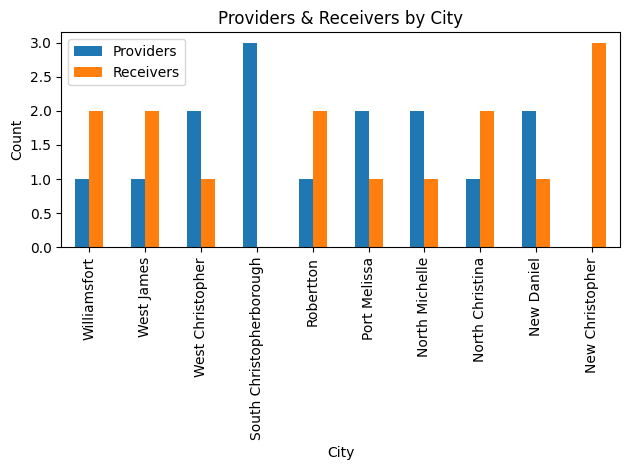

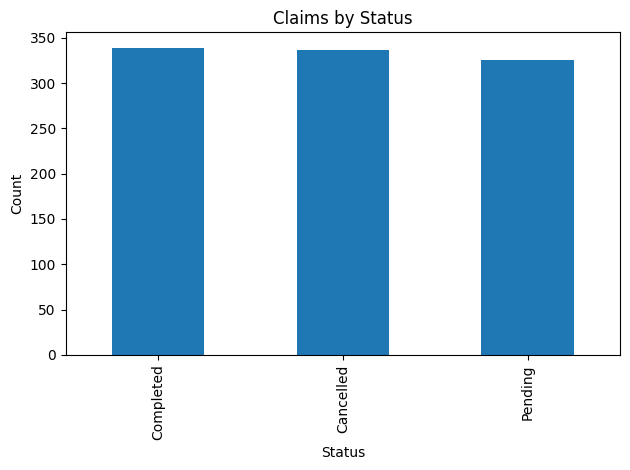

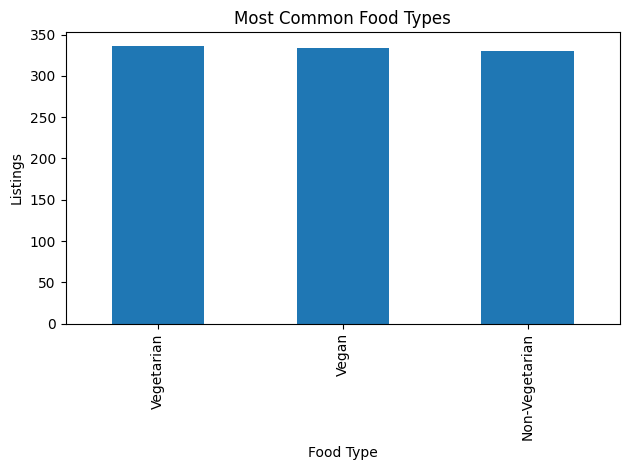

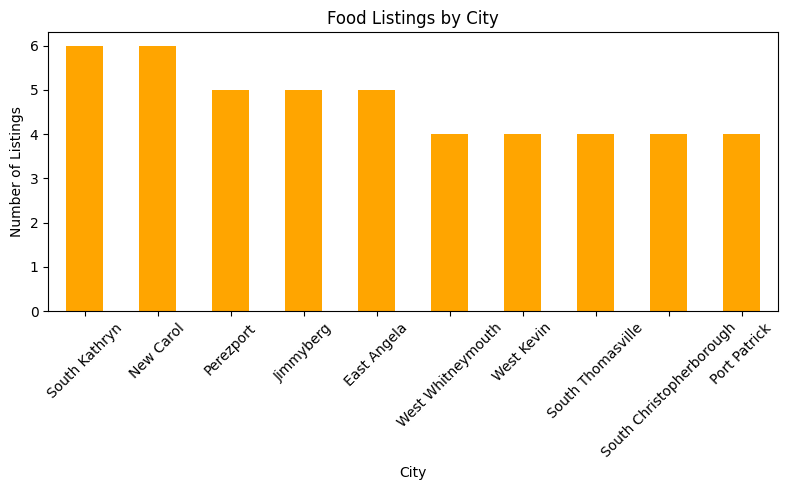

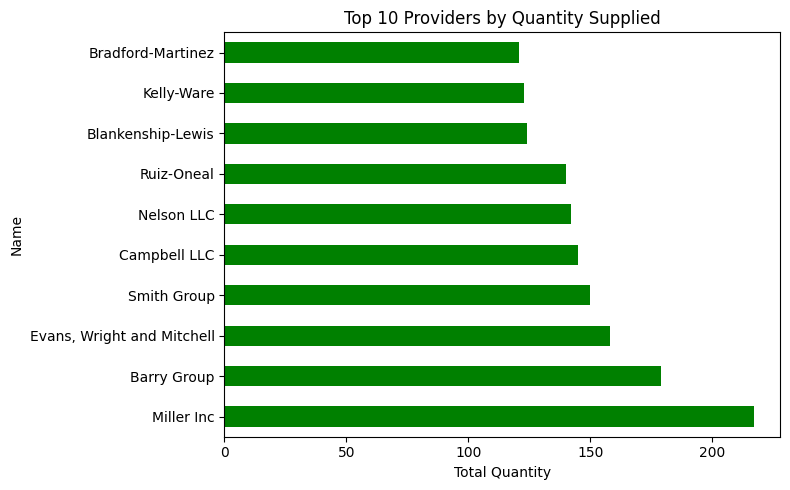

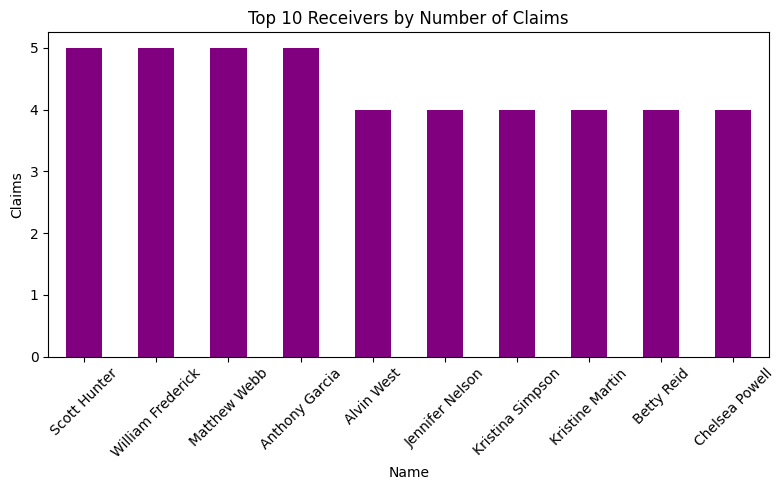

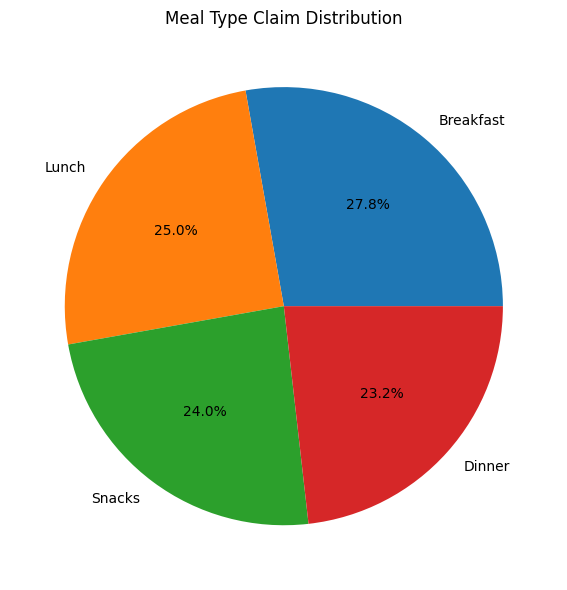

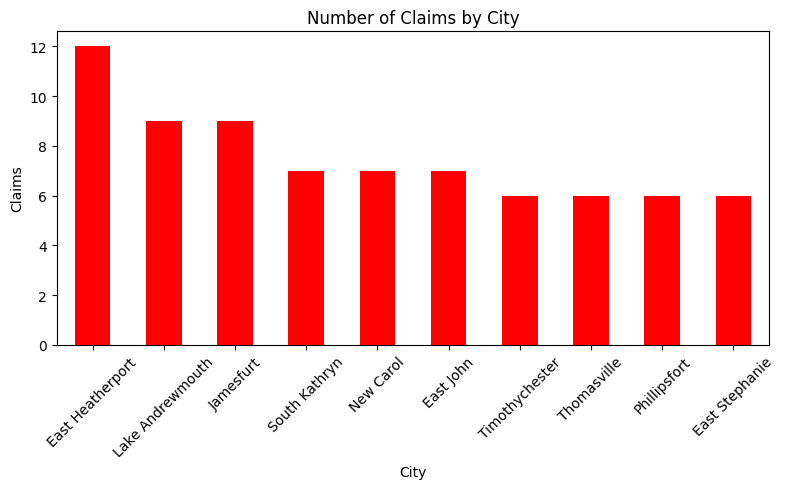

In [29]:
import matplotlib.pyplot as plt

#1. Providers vs Receivers
pr = results['providers_receivers_by_city'].set_index('City')
pr[['Providers','Receivers']].plot(kind='bar')
plt.title('Providers & Receivers by City')
plt.xlabel('City'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

#2. Claim Status
cs = results['claim_status_percentages'].set_index('Status')
cs['cnt'].plot(kind='bar')
plt.title('Claims by Status')
plt.xlabel('Status'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

#3. Food Types
ft = results['most_common_food_types'].set_index('Food_Type')
ft['Count_Listings'].plot(kind='bar')
plt.title('Most Common Food Types')
plt.xlabel('Food Type'); plt.ylabel('Listings')
plt.tight_layout(); plt.show()

# 4. City with Most Listings
city_listings = results['city_with_most_listings'].set_index('City')
city_listings['Listings'].plot(kind='bar', figsize=(8,5), color='orange')
plt.title('Food Listings by City')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# 5. Top Providers by Total Quantity
top_providers_qty = results['total_quantity_by_provider'].nlargest(10, 'Total_Quantity').set_index('Name')
top_providers_qty['Total_Quantity'].plot(kind='barh', figsize=(8,5), color='green')
plt.title('Top 10 Providers by Quantity Supplied')
plt.xlabel('Total Quantity')
plt.tight_layout(); plt.show()

# 6. Top Receivers by Claims
top_receivers_claims = results['top_receivers_by_claims'].nlargest(10, 'Claim_Count').set_index('Name')
top_receivers_claims['Claim_Count'].plot(kind='bar', figsize=(8,5), color='purple')
plt.title('Top 10 Receivers by Number of Claims')
plt.ylabel('Claims')
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# 7. Meal Types Claimed Most
meal_type_claims = results['most_claimed_meal_type'].set_index('Meal_Type')
meal_type_claims['claims'].plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title('Meal Type Claim Distribution')
plt.ylabel('')
plt.tight_layout(); plt.show()

# 8. Claims by City
claims_city = results['claims_by_city'].set_index('City')
claims_city['Claims'].plot(kind='bar', figsize=(8,5), color='red')
plt.title('Number of Claims by City')
plt.ylabel('Claims')
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# ***CRUD for Food_Listings***

In [30]:
# --- CREATE ---
def create_food(food_id, food_name, food_type, meal_type, quantity, expiry_date, provider_id, location):
    query = """
    INSERT INTO Food_Listings (Food_ID, Food_Name, Food_Type, Meal_Type, Quantity, Expiry_Date, Provider_ID, Location)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """
    cursor.execute(query, (food_id, food_name, food_type, meal_type, quantity, expiry_date, provider_id, location))
    conn.commit()
    print("Food listing added successfully!")
    read_food()   # show table after insert

# --- READ ---
def read_food(limit=10):
    df = pd.read_sql_query(f"SELECT * FROM Food_Listings LIMIT {limit};", conn)
    display(df)

# --- UPDATE ---
def update_food_quantity(food_id, new_quantity):
    query = "UPDATE Food_Listings SET Quantity = ? WHERE Food_ID = ?"
    cursor.execute(query, (new_quantity, food_id))
    conn.commit()
    print(f"Food ID {food_id} updated with new quantity {new_quantity}")
    read_food()   # show table after update

# --- DELETE ---
def delete_food(food_id):
    query = "DELETE FROM Food_Listings WHERE Food_ID = ?"
    cursor.execute(query, (food_id,))
    conn.commit()
    print(f"Food ID {food_id} deleted successfully")
    read_food()   # show table after delete

# ***CRUD for Claims***

In [31]:
# --- CREATE ---
def create_claim(claim_id, receiver_id, food_id, status):
    query = """
    INSERT INTO Claims (Claim_ID, Receiver_ID, Food_ID, Status)
    VALUES (?, ?, ?, ?)
    """
    cursor.execute(query, (claim_id, receiver_id, food_id, status))
    conn.commit()
    print("Claim created successfully!")

# --- READ ---
def read_claims():
    df = pd.read_sql_query("SELECT * FROM Claims LIMIT 10;", conn)
    display(df)

# --- UPDATE ---
def update_claim_status(claim_id, new_status):
    query = "UPDATE Claims SET Status = ? WHERE Claim_ID = ?"
    cursor.execute(query, (new_status, claim_id))
    conn.commit()
    print(f"Claim ID {claim_id} updated to status {new_status}")

# --- DELETE ---
def delete_claim(claim_id):
    query = "DELETE FROM Claims WHERE Claim_ID = ?"
    cursor.execute(query, (claim_id,))
    conn.commit()
    print(f"Claim ID {claim_id} deleted successfully")
